## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу. Проанализируйте данные.
2. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
3. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

## Импортируем нужные библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [2]:
warnings.filterwarnings('ignore') 
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
%matplotlib inline

In [3]:
# Исходные данные
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

### Напишем функции для упрощения работы (DRY)

In [4]:
# Общая информация:
def df_info(df):
    df.info()
    display(df.head())


# Функция для построения графика распределения:
def hist(df, column, title, bins):
    plt.figure(figsize=(16, 12))
    plt.title(title, fontsize=16)
    sns.distplot(df[column], bins=bins, kde=True)
    plt.grid(True)


# функция для построения boxplot'а:
def boxplot(df, column, title):
    plt.figure(figsize=(16, 12))
    sns.boxplot(data=df[column])
    plt.title(title, fontsize=16)
    plt.grid(True)
    plt.show()


# Функция для нахождения тренда, сезонности и остатка:
def decompose(df):
    decomposed = seasonal_decompose(df)
    plt.figure(figsize=(16, 12))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    
    plt.tight_layout()
    
    
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_train.columns).sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(12,6))
    sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

## Общий вгзляд на датасет

In [5]:
df_info(taxi)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


*Данные разбиты в интервале [2018-03; 2018-08] с шагом 10 мин. Можно сократить кол-во строк с помощью увеличения шага в 1 час*

In [6]:
taxi=taxi.sort_index().resample('1H').sum()
df_info(taxi)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Посмотрим на изменение кол-ва заказов на всем промежутке времени

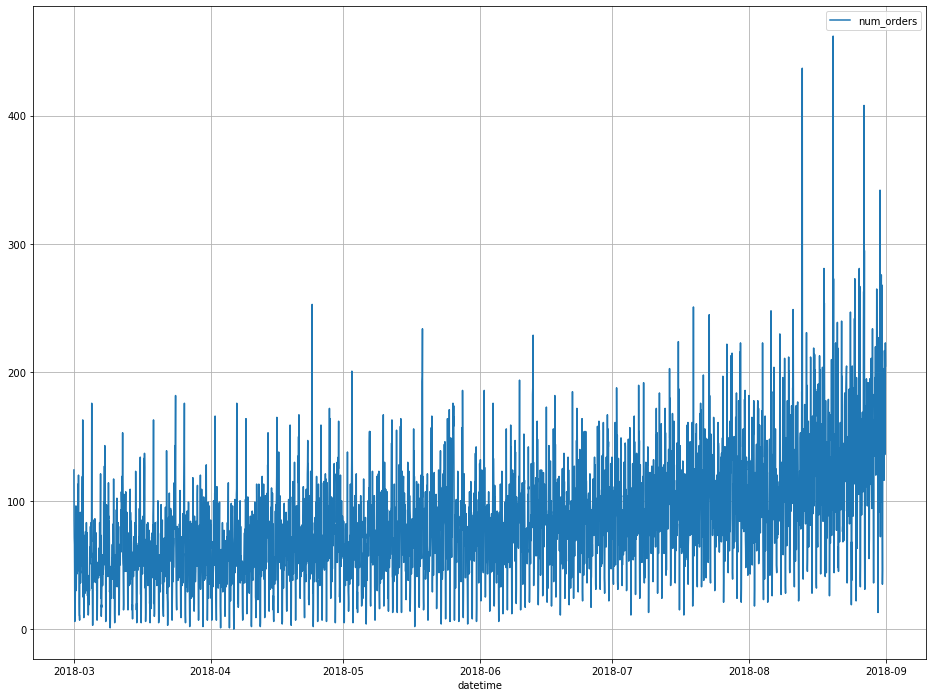

In [7]:
plt.figure(figsize=(16,12))
sns.lineplot(data=taxi)
plt.grid(True)

*Шумновато, но все же видно, что идет прирост*

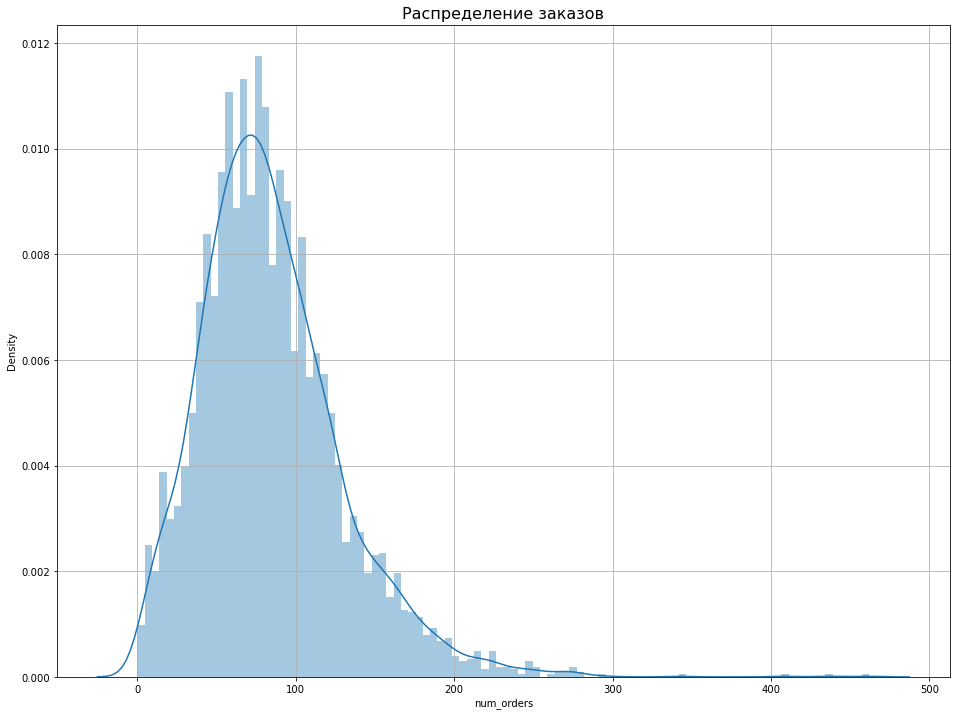

In [8]:
# Распределение заказов:
hist(taxi, 'num_orders', 'Распределение заказов', 100)

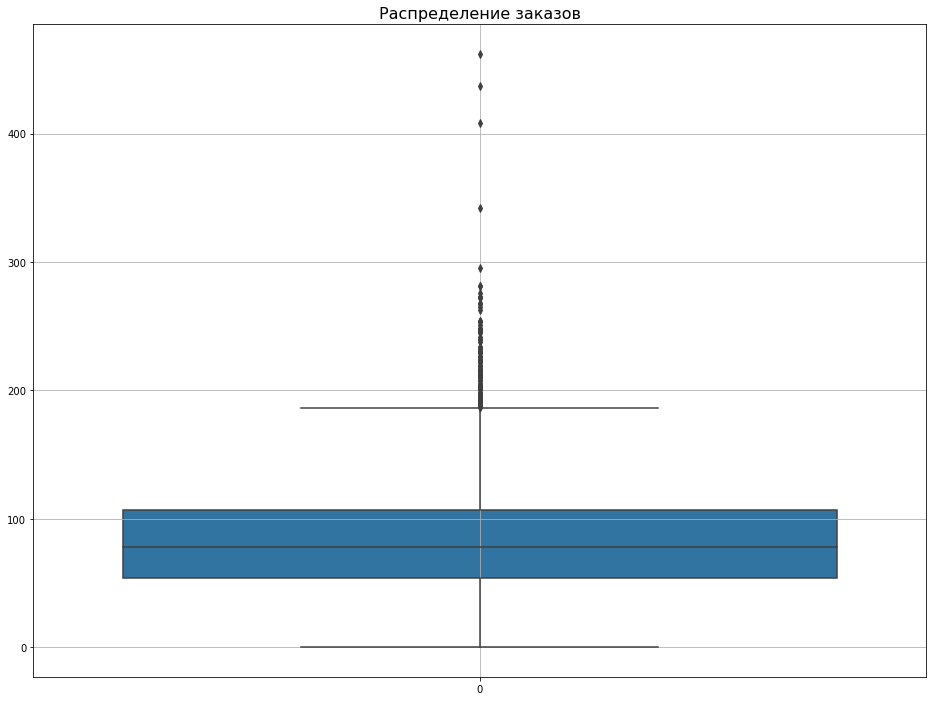

In [9]:
boxplot(taxi, 'num_orders', 'Распределение заказов')

*Распределение близко к нормальному, смещено влево. Выбросы имеются*

### Построим графики тренда, сезонности и остатков 

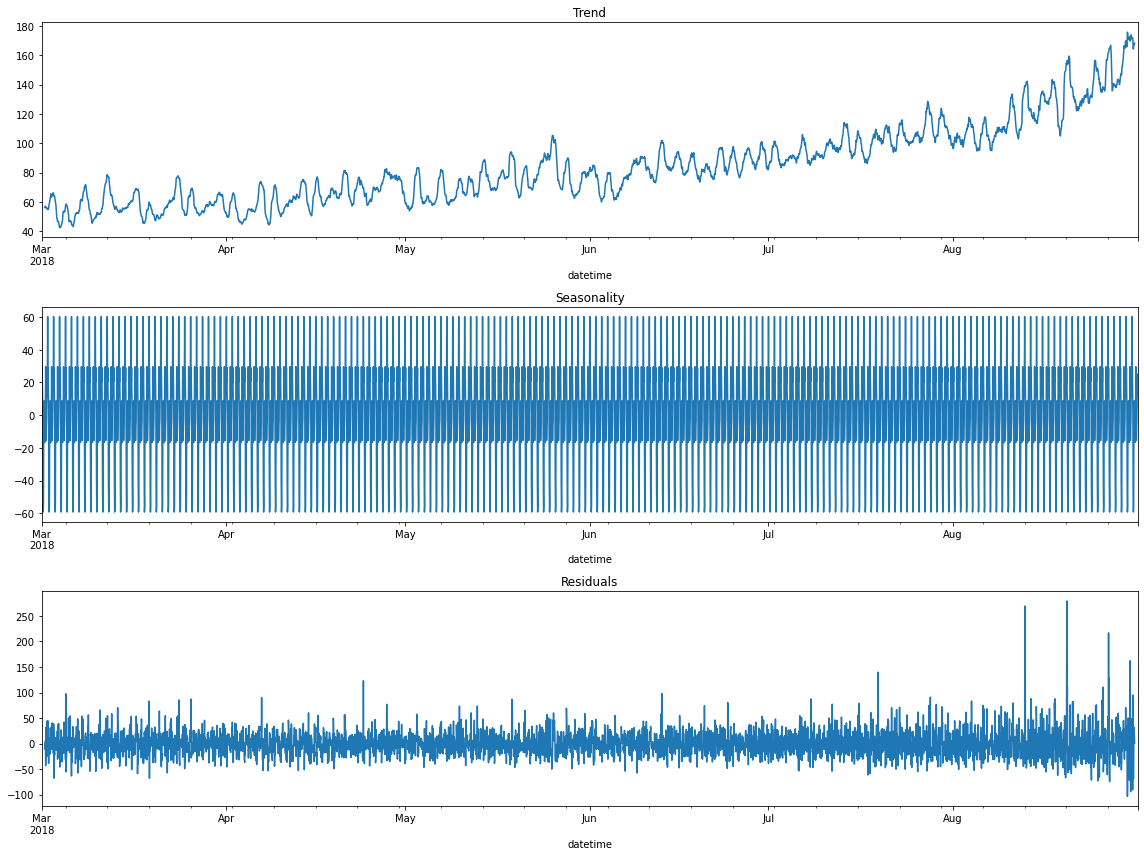

In [10]:
decompose(taxi)

*Увеличение с марта по август, сезонность присутствует, имеются шумы*

*Рассмотрим графики в промежутке 1 недели*

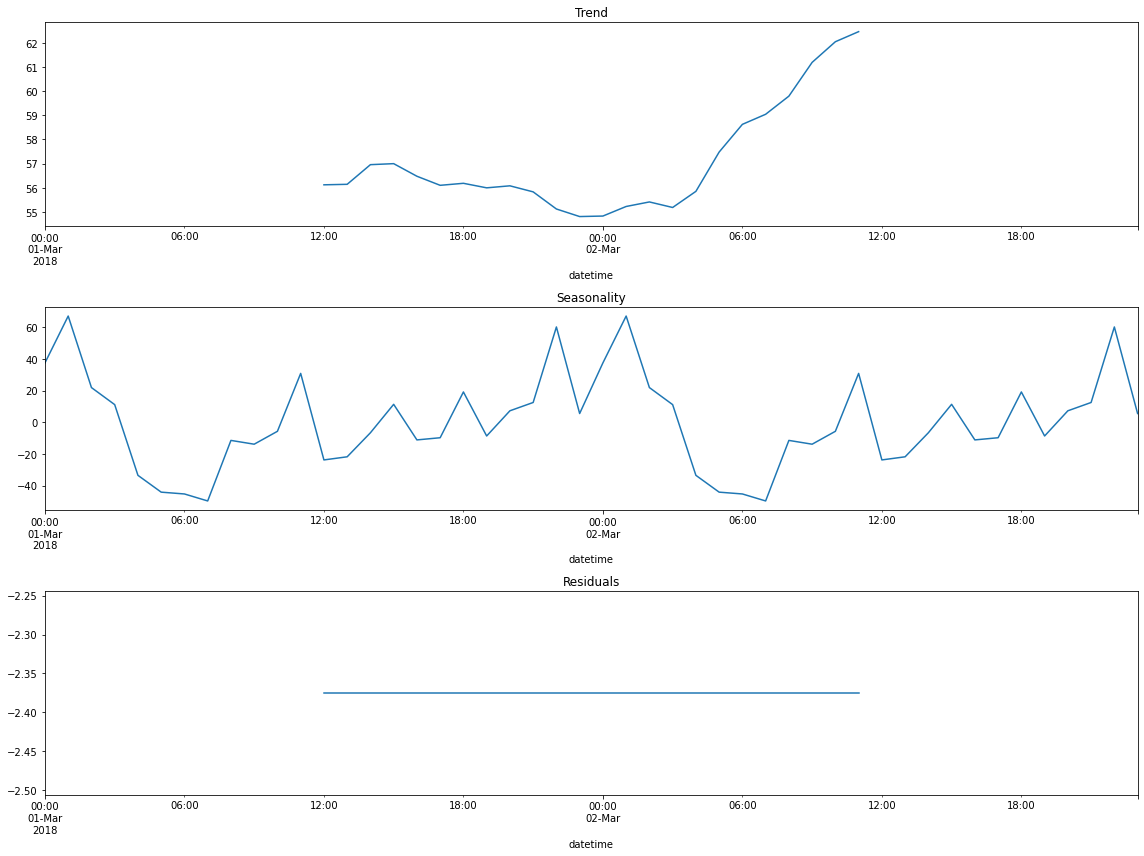

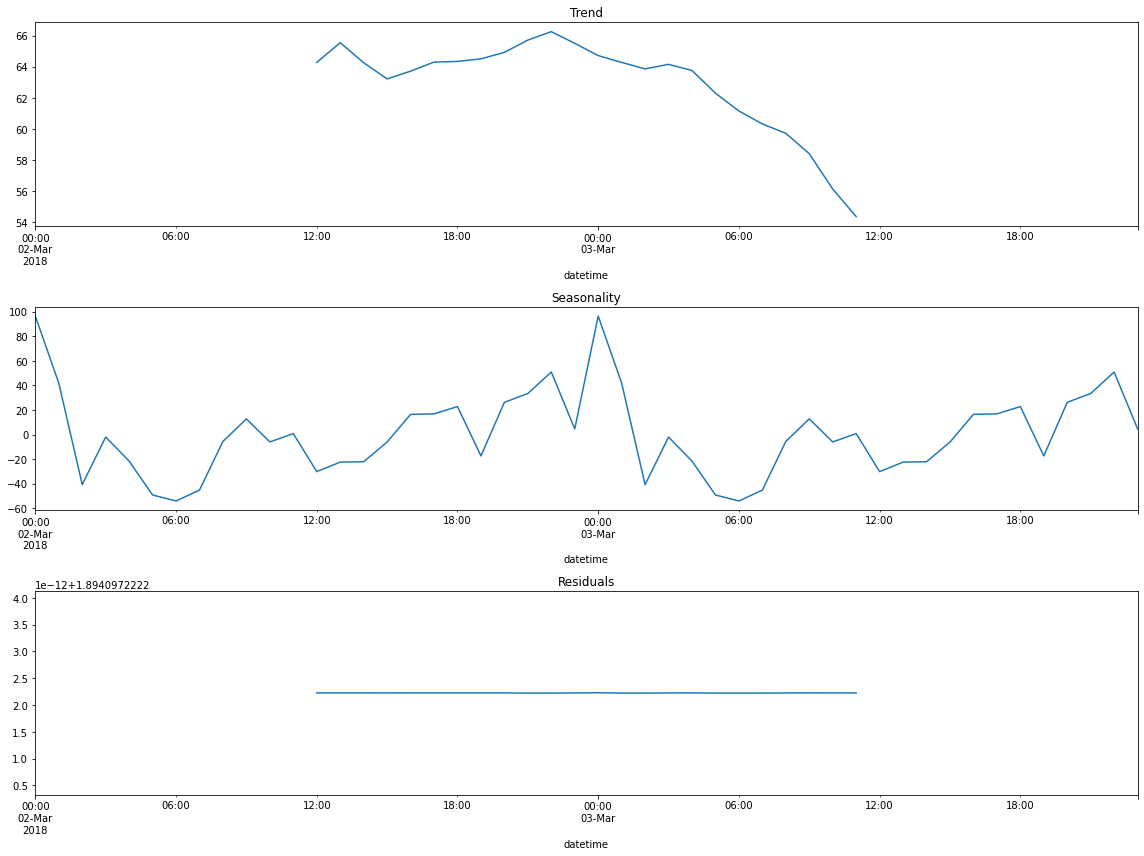

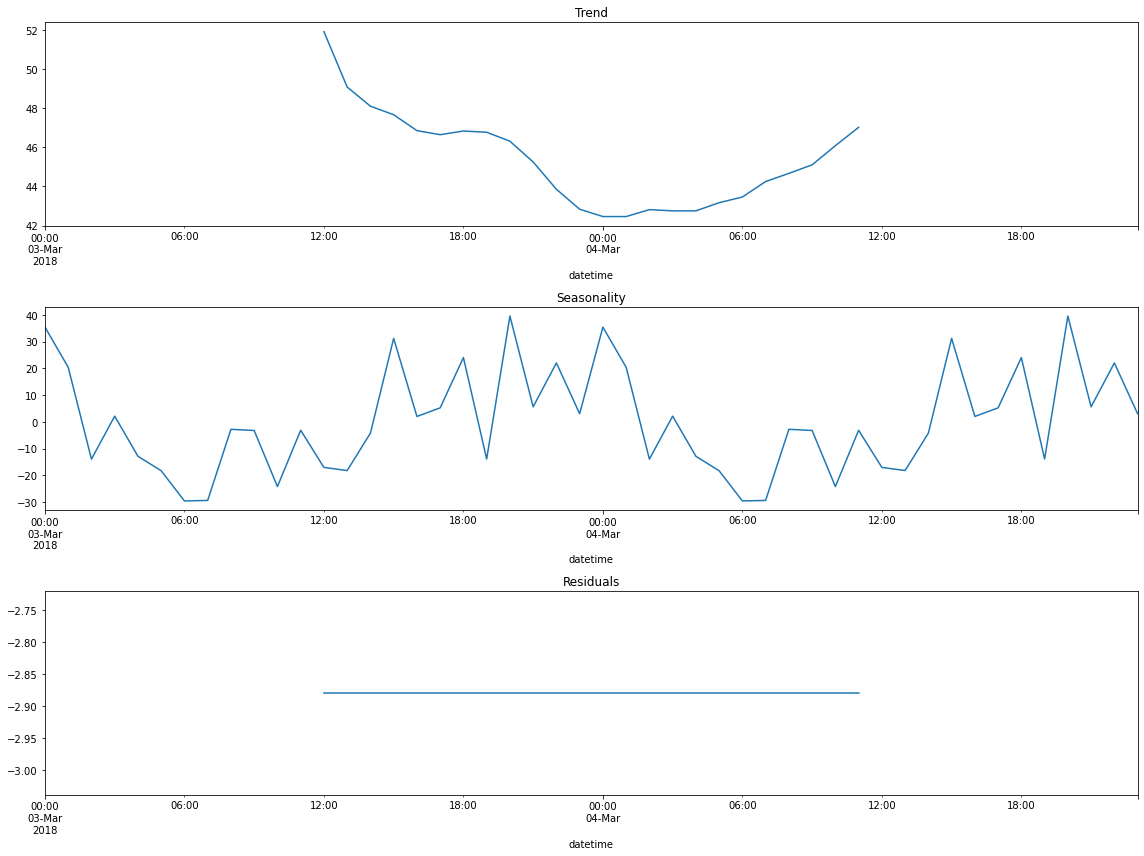

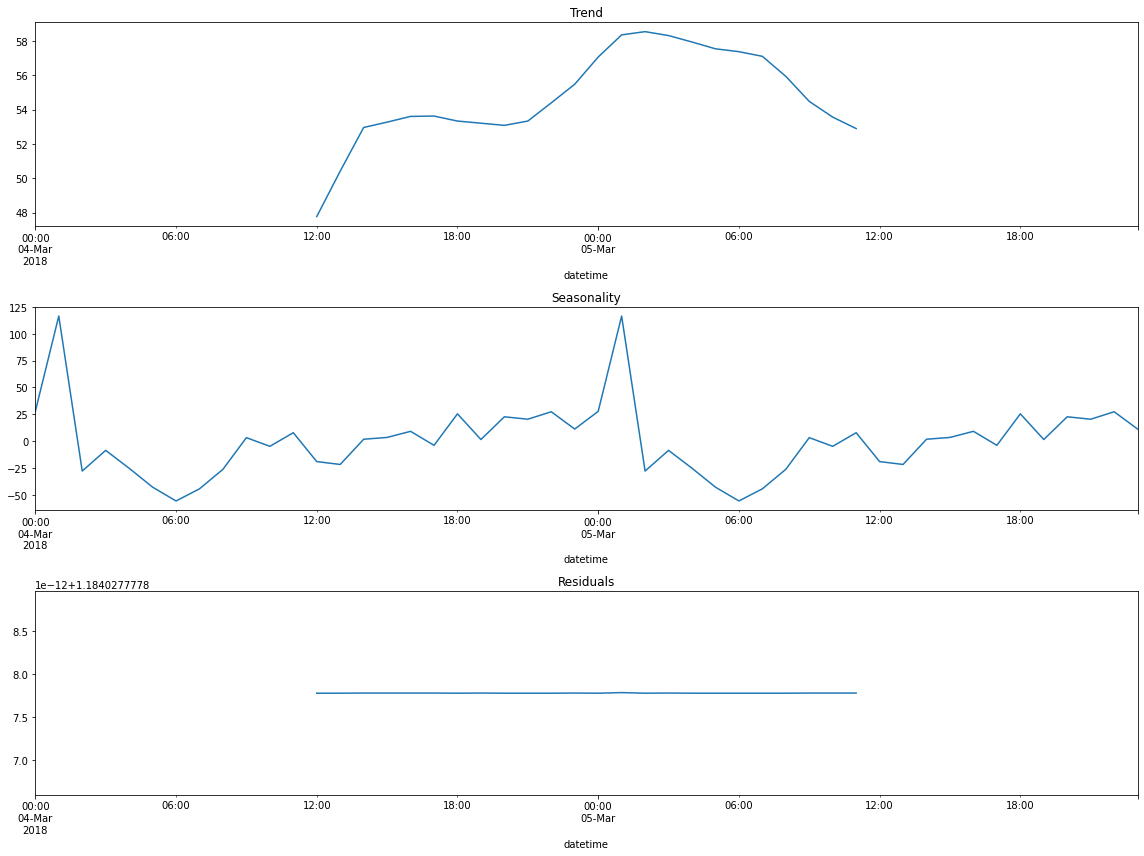

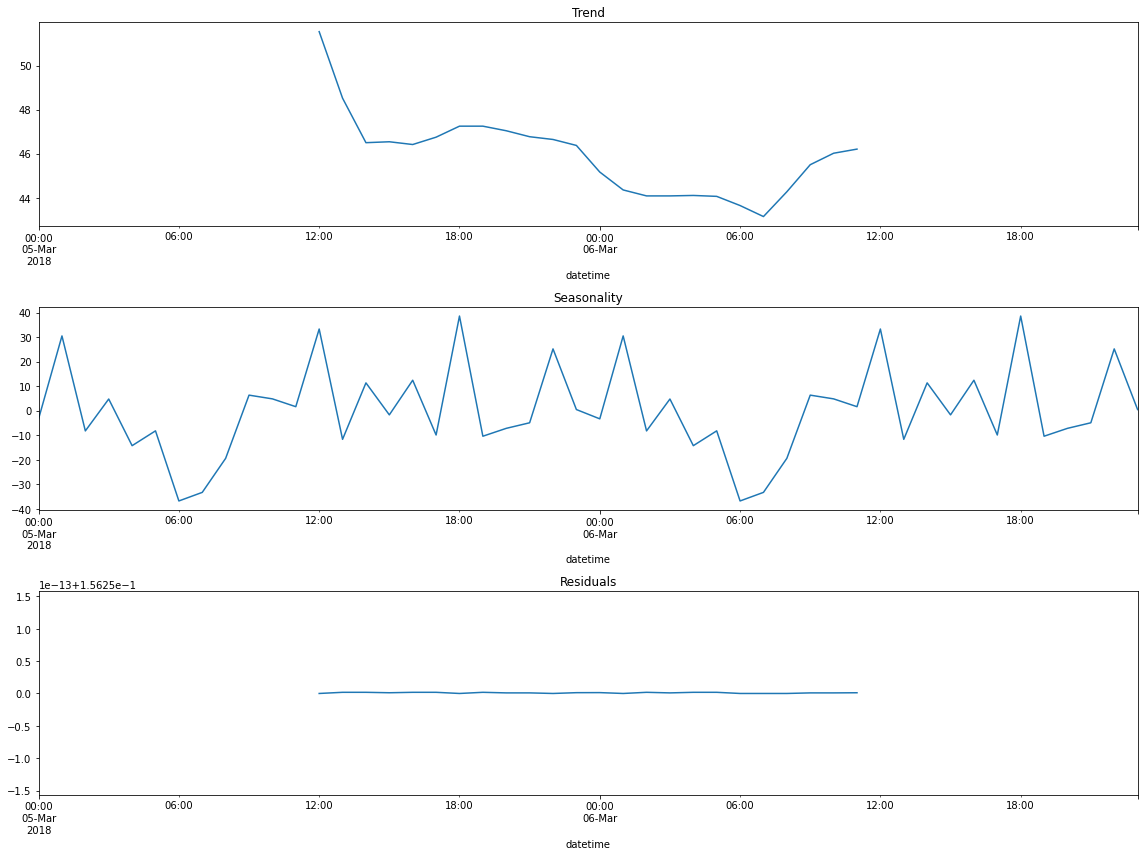

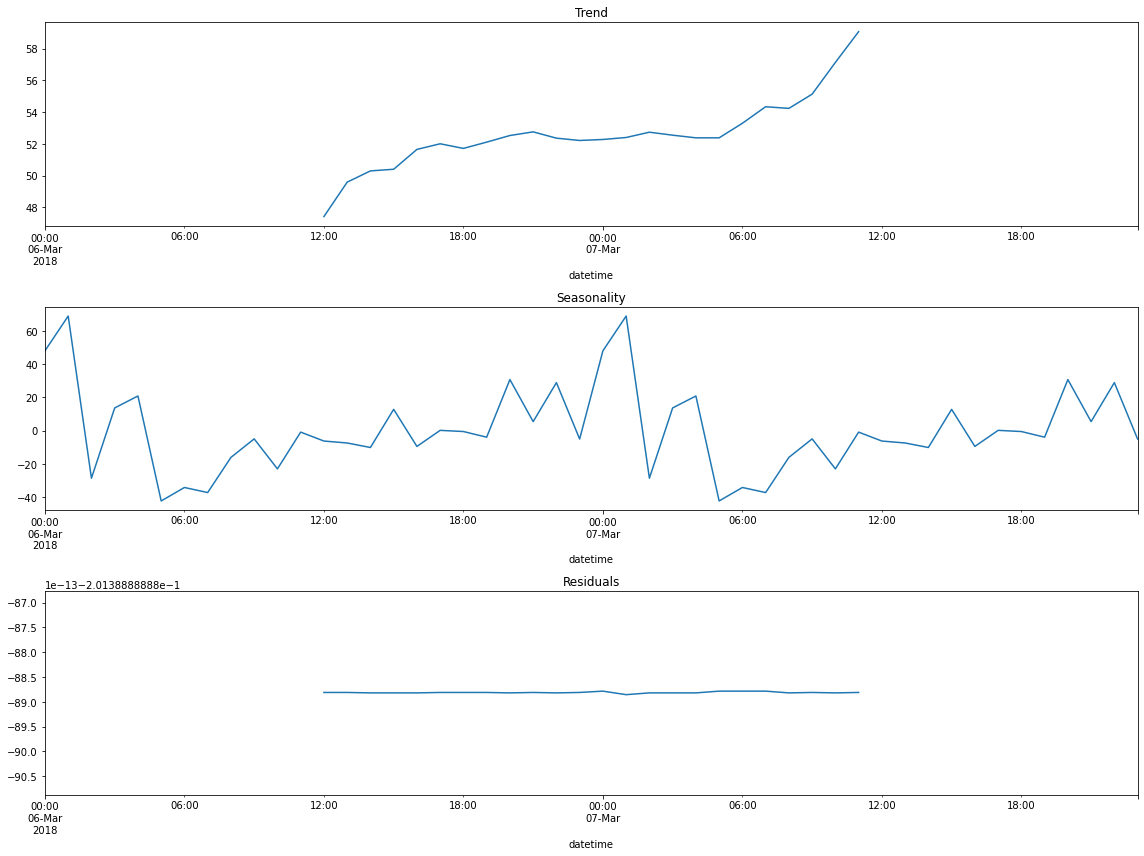

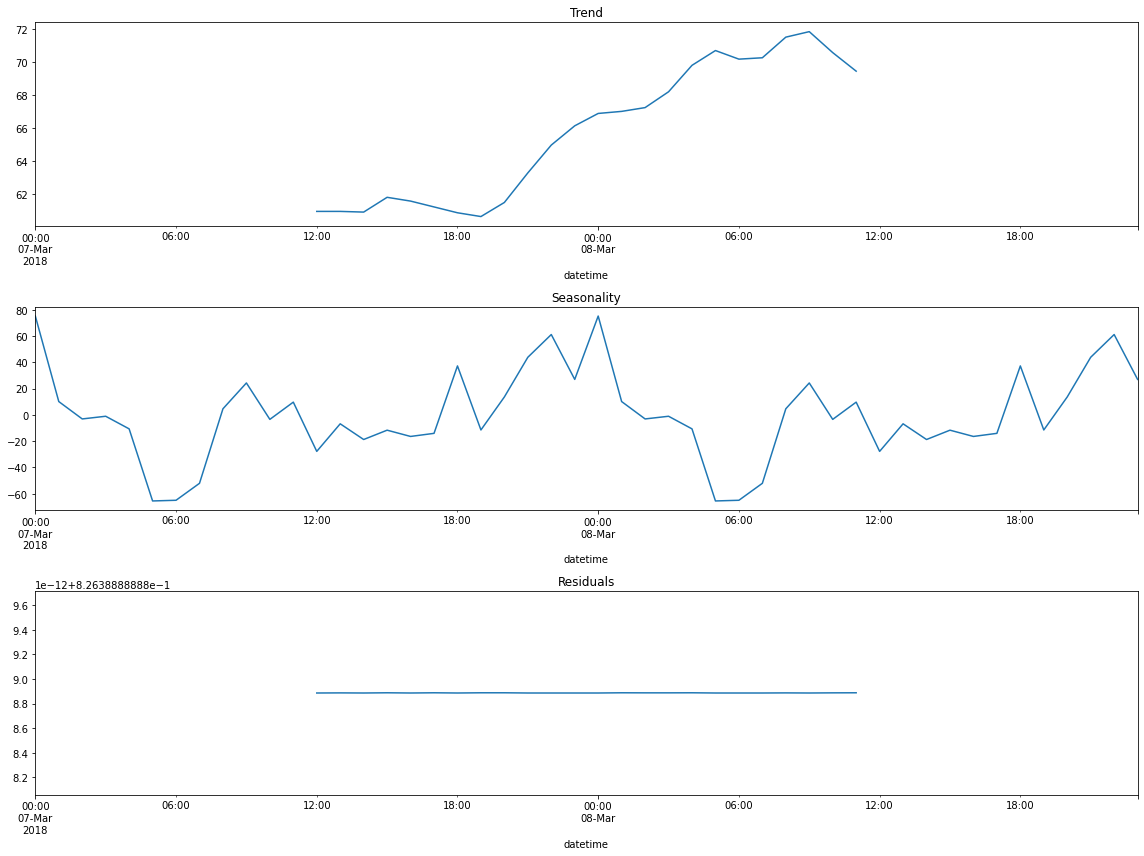

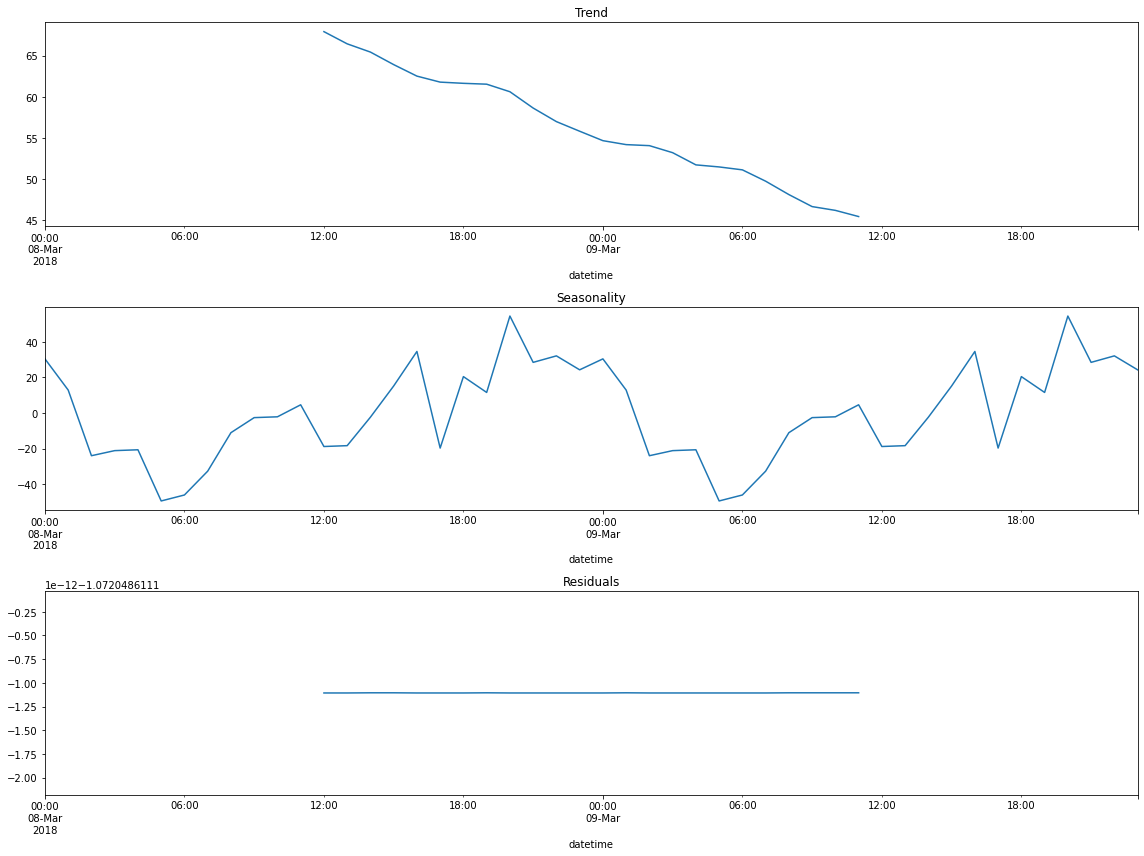

In [11]:
for i in range(1, 9):
    decompose(taxi[f'2018-03-0{str(i)}':f'2018-03-0{str(i+1)}'])

*Что ж, теперь мы понимаем, что во вт и вс у нас явно не прибыльные дни, так как заказы в эти дни падают. Но, если судить по общей недели, то заказы растут*

## Вывод

*Был произведен общий взгляд на датасет. Пропусков нет. Распределение близко к нормальному и смещено влево, присутствуют выбросы*

# 2. Обучение

Перед тем, как обучать модель, нужно будет подготовить данные:
- Создать новые признаки
- Разбить датасет на обучающую и тестовую (10% от исходника) выборки    

In [12]:
def preparation(df, lag_start, lag_end, test_size, rolling_mean_size):
    df = pd.DataFrame(df.copy())
    df.columns = ['target']
    
    df['rolling_mean'] = df['target'].shift().rolling(rolling_mean_size).mean()
    
    # Добавим столбцы с лагами
    for i in range(lag_start, lag_end):
        df[f'lag_{str(i)}'] = df['target'].shift(i)
        
    # Добавим доп признаким
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    
    # Удалим пропуски
    df = df.dropna().reset_index(drop=True)
    
    # Разбивка датасета на обучащую и тестовую выборки
    train, test = train_test_split(df, test_size=test_size, shuffle=False)
    
    # Выделим признаки и целевой признак
    features_train = train.drop(['target'], axis=1)
    target_train = train['target']
    features_test = test.drop(['target'], axis=1)
    target_test = test['target']
    
    return features_train, features_test, target_train, target_test

In [13]:
features_train, features_test, target_train, target_test = preparation(taxi, 1, 11, 0.1, 10)

Вычислим наилучшую метрику RMSE на кросс-валидации и подберем для моделей наилучшие гиперпараметры. Кросс-валидацию мы будем проводить с помощью TimeSeriesSplit, которая учитывает расположение фолдов и не меняет их местами, как при обычной кросс-валидации

In [14]:
tscv = TimeSeriesSplit(n_splits=3)

In [15]:
display(features_train.head())

,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,hour,day,dayofweek,month
0,52.5,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,10,1,3,3
1,46.5,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,11,1,3,3
2,47.6,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,12,1,3,3
3,43.5,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,13,1,3,3
4,40.1,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,14,1,3,3


*В данных присутствуют колличественные признаки с разными разбросами значений. Для того, чтобы алгоритм не решил, что признаки с большими значениями и разбросом важнее, маcштабируем количественные признаки*

In [16]:
numeric = ['rolling_mean'] + features_train.columns[features_train.columns.str.contains('lag')].to_list()
scaler = MinMaxScaler()
scaler.fit(features_train[numeric])

# масштабируем обучающую выборку
features_train[numeric] = scaler.transform(features_train[numeric])

# масштабируем тестовую выборку
features_test[numeric] = scaler.transform(features_test[numeric])

### Обучим модели и проверим результаты

#### Линейная регрессия

In [17]:
def lr_gridsearch(features, target):
    model = LinearRegression()
    param_grid = {
        'copy_X': [True, False],
        'fit_intercept' : [True, False],
        'normalize': [True, False]
    }
    
    CV = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
    CV.fit(features, target)
    
    print('Лучшее значение метрики RMSE: {:.2f}'.format((-CV.best_score_) ** .5))
    print('Лучшие гиперпараметры: ', CV.best_params_)
    return CV.best_params_

In [18]:
%%time
best_params_lr = lr_gridsearch(features_train, target_train)

Лучшее значение метрики RMSE: 32.65
Лучшие гиперпараметры:  {'copy_X': True, 'fit_intercept': True, 'normalize': True}
Wall time: 147 ms


#### KNeighborsRegressor

In [19]:
def knn_gridsearch(features, target):
    model = KNeighborsRegressor()
    param_grid = {
        'n_neighbors' : range(1,5),
        'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    }
    
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv=tscv, scoring = 'neg_mean_squared_error')
    CV.fit(features, target)
    
    print('Лучшее значение метрики RMSE: {:.2f}'.format((-CV.best_score_) ** .5))
    print('Лучшие гиперпараметры: ', CV.best_params_)
    return CV.best_params_

In [20]:
%%time
best_params_knn = knn_gridsearch(features_train, target_train)

Лучшее значение метрики RMSE: 33.52
Лучшие гиперпараметры:  {'algorithm': 'auto', 'n_neighbors': 4}
Wall time: 1.07 s


#### LGBMRegressor

In [21]:
def lgbm_gridsearch(features, target):
    model = LGBMRegressor()
    param_grid = {
            'n_jobs': [-1],
            'boosting_type': ['gbdt', 'goss', 'rf'],
            'objective': ['regression'],
            'n_estimators': [500],
            'learning_rate': [0.01, 0.1, 0.15],
            'max_depth': np.arange(4, 10),
            'random_state': [42],
    }
    
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv=tscv, scoring = 'neg_mean_squared_error')
    CV.fit(features, target)
    
    print('Лучшее значение метрики RMSE: {:.2f}'.format((-CV.best_score_) ** .5))
    print('Лучшие гиперпараметры: ', CV.best_params_)
    return CV.best_params_

In [22]:
%%time
best_param_lgbm = lgbm_gridsearch(features_train, target_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

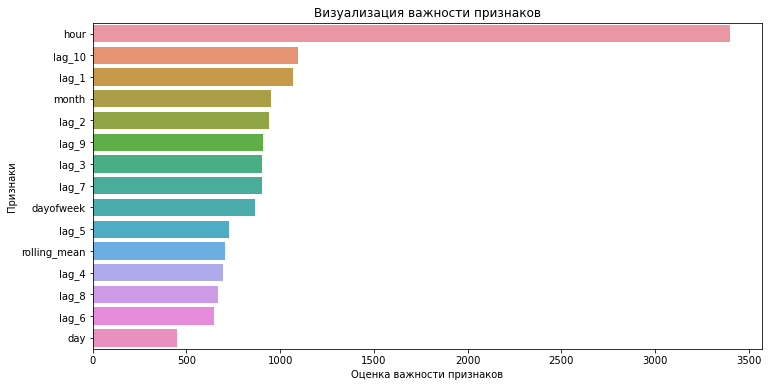

In [23]:
model_lgbm = LGBMRegressor(**best_param_lgbm)
model_lgbm.fit(features_train, target_train)
chart_feature_imp(model_lgbm)

#### CatBoostRegressor

In [24]:
def catboost_gridsearch(features, target):
    model = CatBoostRegressor()
    param_grid = {
        'n_estimators': [500],
        'learning_rate': [0.01, 0.1, 0.15],
        'depth': np.arange(4, 10),
        'random_state': [42],
        'boosting_type': ['Plain']
    }
    CV = model.grid_search(param_grid, 
                           X=features, 
                           y=target, 
                           cv=tscv)
    print('Лучшее значение метрики RMSE: {:.2f}'.format(model.get_best_score()['learn']['RMSE']))
    print('Лучшие гиперпараметры: ', CV['params'])
    return  CV['params']

In [25]:
%%time
best_param_catboost = catboost_gridsearch(features_train, target_train)


bestTest = 36.2836302
bestIteration = 499

0:	loss: 36.2836302	best: 36.2836302 (0)	total: 758ms	remaining: 12.9s

bestTest = 30.82344316
bestIteration = 229

1:	loss: 30.8234432	best: 30.8234432 (1)	total: 1.45s	remaining: 11.6s

bestTest = 30.93519454
bestIteration = 211

2:	loss: 30.9351945	best: 30.8234432 (1)	total: 2.14s	remaining: 10.7s

bestTest = 35.97614659
bestIteration = 499

3:	loss: 35.9761466	best: 30.8234432 (1)	total: 2.98s	remaining: 10.4s

bestTest = 30.50510088
bestIteration = 383

4:	loss: 30.5051009	best: 30.5051009 (4)	total: 3.84s	remaining: 9.98s

bestTest = 31.41683026
bestIteration = 210

5:	loss: 31.4168303	best: 30.5051009 (4)	total: 4.67s	remaining: 9.35s

bestTest = 35.51936709
bestIteration = 499

6:	loss: 35.5193671	best: 30.5051009 (4)	total: 5.71s	remaining: 8.97s

bestTest = 31.03963716
bestIteration = 300

7:	loss: 31.0396372	best: 30.5051009 (4)	total: 6.75s	remaining: 8.43s

bestTest = 30.72879636
bestIteration = 284

8:	loss: 30.7287964	best: 30

0:	learn: 36.9413201	total: 3.21ms	remaining: 1.6s
1:	learn: 35.3575673	total: 6.62ms	remaining: 1.65s
2:	learn: 33.9189379	total: 8.57ms	remaining: 1.42s
3:	learn: 32.8356125	total: 10.2ms	remaining: 1.27s
4:	learn: 32.0514111	total: 12ms	remaining: 1.18s
5:	learn: 31.0416659	total: 13.7ms	remaining: 1.13s
6:	learn: 30.3896451	total: 15.4ms	remaining: 1.09s
7:	learn: 29.8046488	total: 17.2ms	remaining: 1.05s
8:	learn: 29.2174890	total: 19.5ms	remaining: 1.06s
9:	learn: 28.6008881	total: 21.3ms	remaining: 1.04s
10:	learn: 28.0487370	total: 23ms	remaining: 1.02s
11:	learn: 27.6555523	total: 24.6ms	remaining: 1s
12:	learn: 27.2272153	total: 26.4ms	remaining: 988ms
13:	learn: 26.8210046	total: 28.2ms	remaining: 979ms
14:	learn: 26.5426765	total: 29.9ms	remaining: 967ms
15:	learn: 26.3050480	total: 31.8ms	remaining: 963ms
16:	learn: 26.0984389	total: 33.7ms	remaining: 958ms
17:	learn: 25.7974921	total: 35.5ms	remaining: 952ms
18:	learn: 25.6328323	total: 37.4ms	remaining: 947ms
19:	learn: 

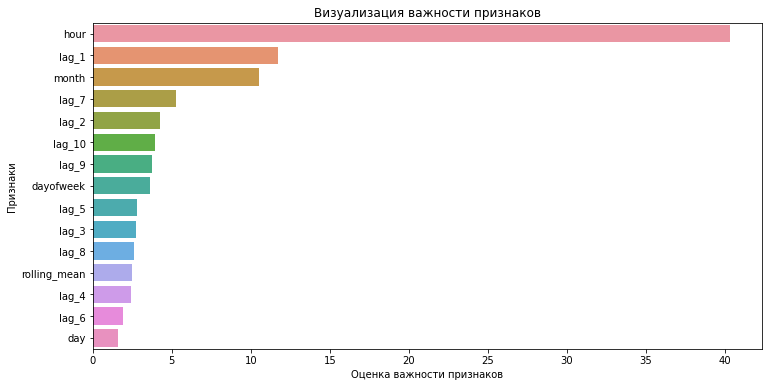

In [26]:
model_cb = CatBoostRegressor(**best_param_catboost)
model_cb.fit(features_train, target_train)
chart_feature_imp(model_cb)

## Вывод

*Результаты явно показали хорошие, все модели выдали значение метрики ниже порога, что очень хорошо. Фаворитом здесь будет CatBoostRegressor, после идет LGBMRegressor, KNN и Линейная регрессия показали себя немного хуже, чем предыдущие модели*

# 3. Тестирование

### Напишем фукцию для проверки модели на тестовой выборке и построения графика с выводами предсказаний и правильных ответов

In [27]:
def test_check(model, features_train, target_train, features_test, target_test):
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)
    rmse = mean_squared_error(predictions, target_test) ** .5
    print(f'RMSE = {round(rmse,2)}')
    actual_and_pred_plot(predictions, target_test)
    return round(rmse, 2)
    
def actual_and_pred_plot(predictions, target_test):
    plt.figure(figsize=(16, 12))
    plt.plot(predictions, 'r', label='Predictions')
    plt.plot(target_test.values, label='Target')
    plt.legend(loc='best')
    metric = round(mean_squared_error(predictions, target_test) ** .5, 2)
    plt.title(f'RMSE {metric}')
    plt.grid(True)

#### Линейная регрессия

RMSE = 53.52


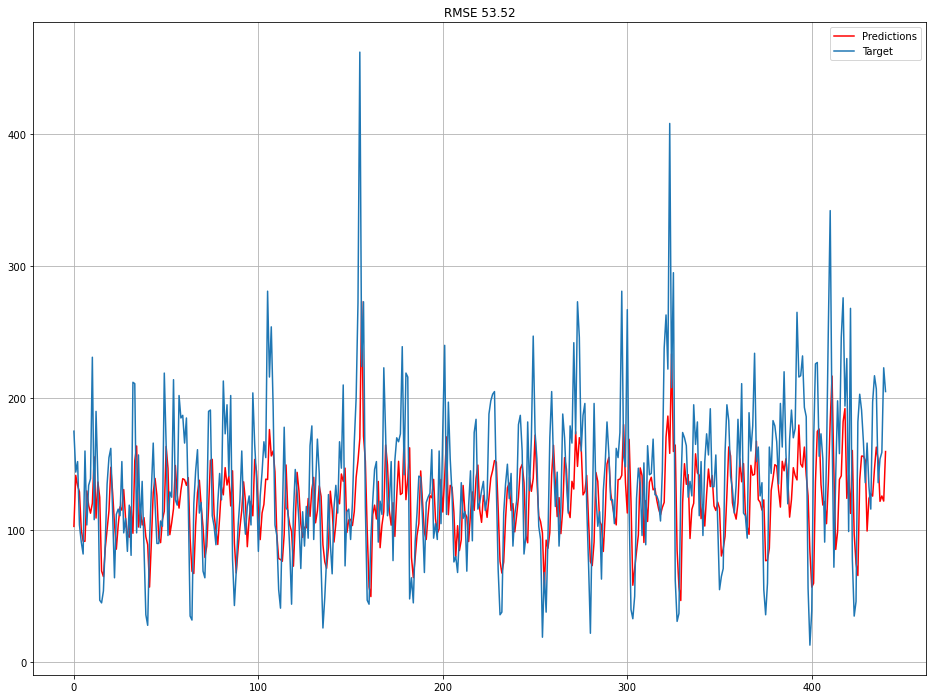

In [28]:
model_lr = LinearRegression(**best_params_lr)
linear_rmse = test_check(model_lr, features_train, target_train, features_test, target_test)

#### KNeighborsRegressor

RMSE = 64.99


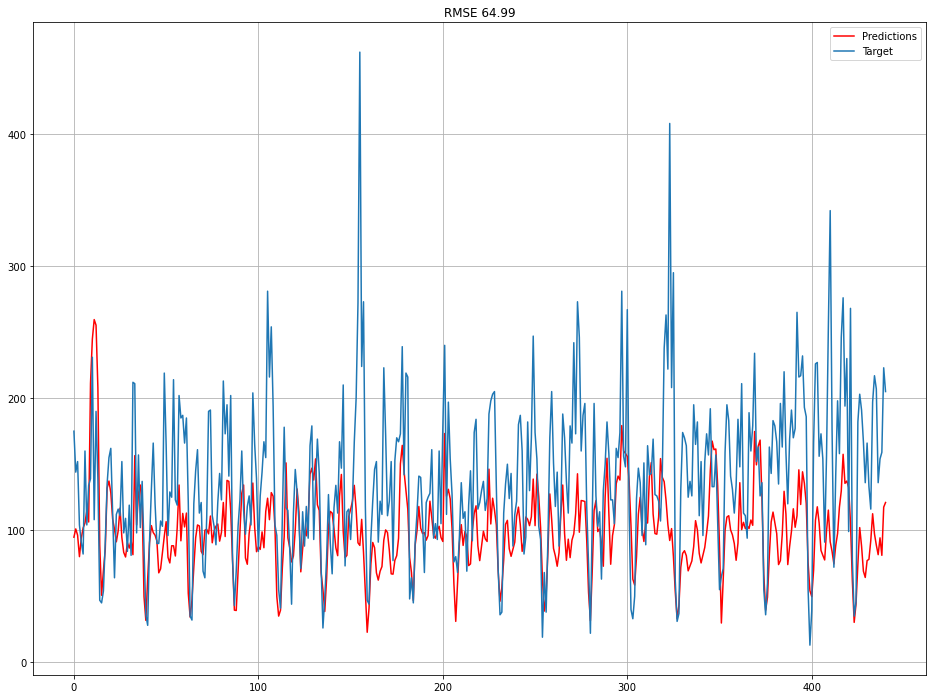

In [29]:
model_knn = KNeighborsRegressor(**best_params_knn)
knr_rmse = test_check(model_knn, features_train, target_train, features_test, target_test)

#### LGBMRegressor

RMSE = 43.32


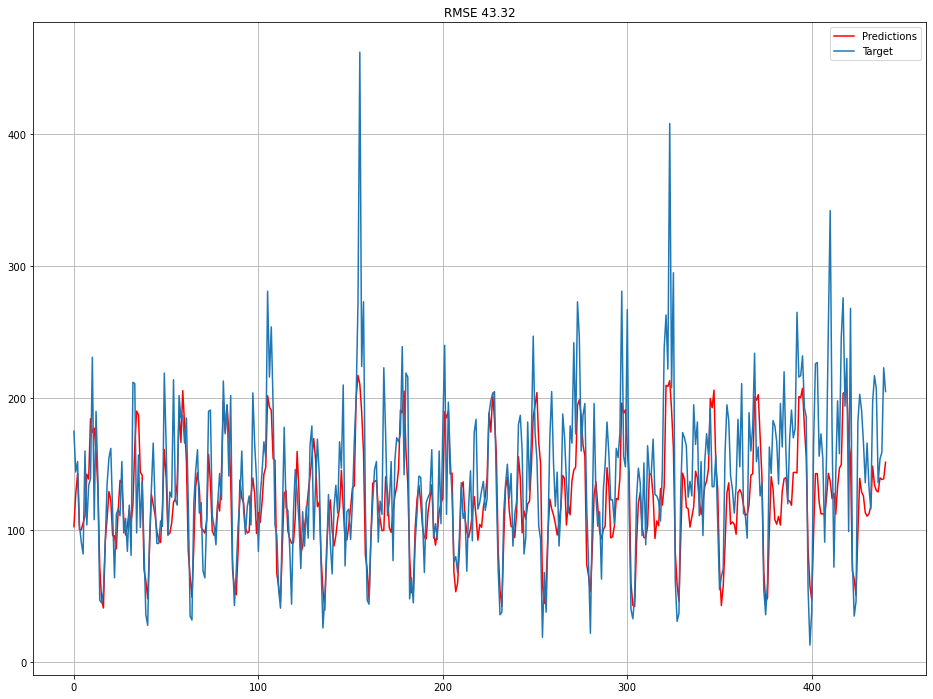

In [30]:
model_lgbm = LGBMRegressor(**best_param_lgbm)
lgbm_rmse = test_check(model_lgbm, features_train, target_train, features_test, target_test)

#### CatBoostRegressor

0:	learn: 36.9413201	total: 2.97ms	remaining: 1.48s
1:	learn: 35.3575673	total: 4.88ms	remaining: 1.22s
2:	learn: 33.9189379	total: 6.56ms	remaining: 1.09s
3:	learn: 32.8356125	total: 8.22ms	remaining: 1.02s
4:	learn: 32.0514111	total: 9.95ms	remaining: 985ms
5:	learn: 31.0416659	total: 11.6ms	remaining: 957ms
6:	learn: 30.3896451	total: 13.3ms	remaining: 936ms
7:	learn: 29.8046488	total: 15ms	remaining: 921ms
8:	learn: 29.2174890	total: 16.6ms	remaining: 906ms
9:	learn: 28.6008881	total: 18.7ms	remaining: 917ms
10:	learn: 28.0487370	total: 20.4ms	remaining: 906ms
11:	learn: 27.6555523	total: 22ms	remaining: 897ms
12:	learn: 27.2272153	total: 23.8ms	remaining: 890ms
13:	learn: 26.8210046	total: 25.4ms	remaining: 883ms
14:	learn: 26.5426765	total: 27.1ms	remaining: 876ms
15:	learn: 26.3050480	total: 29ms	remaining: 878ms
16:	learn: 26.0984389	total: 30.9ms	remaining: 877ms
17:	learn: 25.7974921	total: 32.7ms	remaining: 875ms
18:	learn: 25.6328323	total: 34.4ms	remaining: 872ms
19:	learn

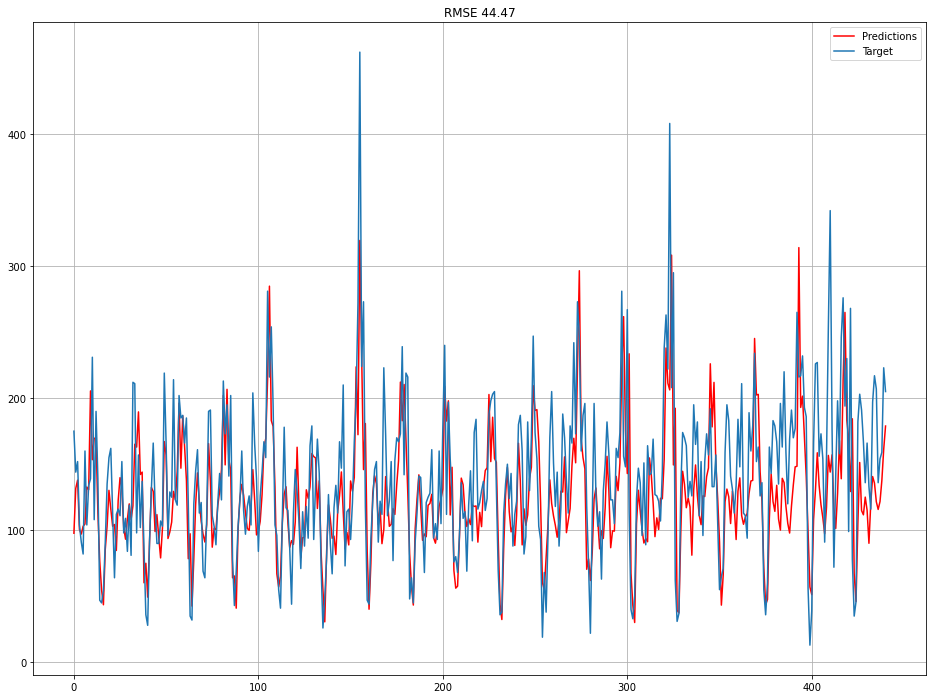

In [31]:
model_catboost = CatBoostRegressor(**best_param_catboost)
catboost_rmse = test_check(model_catboost, features_train, target_train, features_test, target_test)

#### Dummy

In [32]:
# Предсказание, которое предсказывыет предыдущее значение временного ряда
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
rmse_naive = round(mean_squared_error(target_test, pred_previous)**0.5, 2)
print('RMSE наивного предсказания: ', rmse_naive)

RMSE наивного предсказания:  58.92


In [33]:
d = {'RMSE': [linear_rmse, knr_rmse, lgbm_rmse, catboost_rmse], 'RMSE(mean)' : [rmse_naive, rmse_naive, rmse_naive, rmse_naive]}
final = pd.DataFrame(data=d, index = ['Линейная регрессия', 'KNeighborsRegressor', 'LGBMRegressor', 'CatBoostRegressor'])
display(final)

,RMSE,RMSE(mean)
Линейная регрессия,53.52,58.92
KNeighborsRegressor,64.99,58.92
LGBMRegressor,43.32,58.92
CatBoostRegressor,44.47,58.92


*Хорошо себя показали на тестовой выборке LGBM и CatBoost*

# Вывод

*Данные были проанализированы, проведено ресемплирование и декомпозиция временного ряда, обучили и проверили на тестовой выборке 4 модели, сделали кросс-валидацию и подобрали лучшие гиперпараметры*